# ChatGPT got a personality!

I have downloaded all my past conversations by exporting data from GPT. Shh secret though since I talk a LOT with GPT. If you want to use your data instead - Head to your account [Lil round icon thingy on the right] -> Data controls -> Export data. You will get a lot of content. Just take the conversations.json file from that downloaded folder for the rest of the code.

## Cleaning data
I tried reading the script and it was well organized but have a lot of metadata, etc. So this simple script extracts just what we need from this

In [6]:
data = "data/conversations.json"

In [ ]:
import json
with open(data, "r") as f:
    json_data = json.load(f)

In [ ]:
def getMessages(conversation):
    messages = []
    cur = conversation.get('current_node')
    
    while cur:
        node = conversation.get('mapping', {}).get(cur, {})
        message = node.get('message', {})
        if message:
            content = message.get('content', {})
            if content:
                parts = content.get('parts', [])
        
                if parts and isinstance(parts, list):
                    author = message.get('author', {}).get('role', 'User')
                    if author in ["assistant", "tool"]:
                        author = "ChatGPT"
                    elif author == "system" or message.get('metadata', {}).get('is_user_system_message'):
                        author = "User"
                    
                    content_type = content.get('content_type')
                    if content_type in ["text", "multimodal_text"]:
                        cleaned_parts = []
                        for part in parts:
                            if isinstance(part, str) and part:
                                cleaned_parts.append( part)
                            elif isinstance(part, dict) and part.get('content_type') == "audio_transcription":
                                cleaned_parts.append(part.get('text', ''))
                            # Ignore file/asset pointers or unsupported types. Maybe add support later to look into these asset pointers
                        if cleaned_parts:
                            if len(cleaned_parts)>1:
                                print("bruh")
                            messages.append({"author": author, "text": cleaned_parts[0]})
        
        cur = node.get('parent')

    messages.reverse()
    return messages


In [37]:
from datetime import datetime
clean = []
for conversation in json_data:
    #print(conversation)
    convo = {"title": conversation['title'], "messages":[], "create-time": datetime.fromtimestamp(conversation['create_time'])}
    convo['messages'] = getMessages(conversation)
    clean.append(convo)
    
    

In [ ]:
clean[1]

In [39]:
len(clean)

337

In [44]:
#Save it for safety!!!

import json
from datetime import datetime

# Custom converter for non-serializable types
def custom_converter(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    return str(obj)  #Fallback

# Save to file with converter
with open("data/cleaned_conversations.json", "w", encoding="utf-8") as f:
    json.dump(clean, f, ensure_ascii=False, indent=2, default=custom_converter)


In [45]:
# Now lets flatten it into a df so that our work is easier
# So each message will be a row, it should have the person who said it - GPT vs user, the title of the conversation, the timestamp of the conversation
# I am thinking let's add say 30 seconds to each message as a position indicator
from datetime import datetime, timedelta

d = []
for conversation in clean:
    startTime = conversation['create-time']
    title = conversation['title']
    time = 0
    for message in conversation['messages']:
        author = message['author']
        content = message['text']
        messageTime = startTime + timedelta(seconds=time)
        time+=30
        d.append([author, content, messageTime, title, startTime])
        


In [48]:
import pandas as pd


df = pd.DataFrame(d, columns=['author', 'content', 'message_time', 'title', 'start_time'])
df.head()


,author,content,message_time,title,start_time
0,user,I am applying to a be a MATS scholar and the s...,2025-04-14 07:02:55.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500
1,ChatGPT,Adithi Narayan is applying to be a MATS schola...,2025-04-14 07:03:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500
2,ChatGPT,Model set context updated.,2025-04-14 07:03:55.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500
3,ChatGPT,Here’s a strong draft for each of your MATS ap...,2025-04-14 07:04:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500
4,user,Let me tell you something - when you suddenly ...,2025-04-14 07:04:55.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import nltk
import re

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("vader_lexicon")
nltk.download('punkt_tab')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [51]:
assistant_df = df[df["author"] == "ChatGPT"].copy()

In [52]:
# -----------------------------
# Add sentence embeddings
# -----------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(assistant_df["content"].tolist(), show_progress_bar=True)
embeddings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\adith\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adith\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

array([[-0.02971557, -0.01886868, -0.03401955, ..., -0.06897145,
         0.01226064, -0.00222874],
       [ 0.00646854, -0.05727115, -0.00579156, ..., -0.04246605,
        -0.05666921,  0.00551332],
       [-0.03857148, -0.01683951,  0.00384865, ..., -0.00524648,
        -0.01803582,  0.03644402],
       ...,
       [ 0.07204581, -0.07127666, -0.01419407, ..., -0.07716531,
         0.04176543,  0.02991493],
       [ 0.03940896, -0.07457995, -0.04551576, ..., -0.02132777,
        -0.00517544, -0.02014014],
       [-0.06890622, -0.0297717 ,  0.02335747, ..., -0.01782296,
         0.02061322,  0.03415374]], dtype=float32)

In [53]:

# -----------------------------
# Sentiment analysis (tone)
# -----------------------------
sia = SentimentIntensityAnalyzer()
sentiments = assistant_df["content"].apply(lambda x: sia.polarity_scores(x))
sentiment_df = pd.DataFrame(list(sentiments))
assistant_df = pd.concat([assistant_df.reset_index(drop=True), sentiment_df], axis=1)

assistant_df.head()

,author,content,message_time,title,start_time,neg,neu,pos,compound
0,ChatGPT,Adithi Narayan is applying to be a MATS schola...,2025-04-14 07:03:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500,0.073,0.783,0.143,0.4005
1,ChatGPT,Model set context updated.,2025-04-14 07:03:55.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500,0.000,1.000,0.000,0.0000
2,ChatGPT,Here’s a strong draft for each of your MATS ap...,2025-04-14 07:04:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500,0.036,0.851,0.113,0.9873
3,ChatGPT,"I love that you asked this—it’s a very ""Adithi...",2025-04-14 07:05:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500,0.023,0.821,0.156,0.9989
4,ChatGPT,Awesome—this is going to be fun. Let's do **tw...,2025-04-14 07:06:25.202500,MATS Application Drafting Assistance,2025-04-14 07:02:55.202500,0.059,0.849,0.092,0.9659


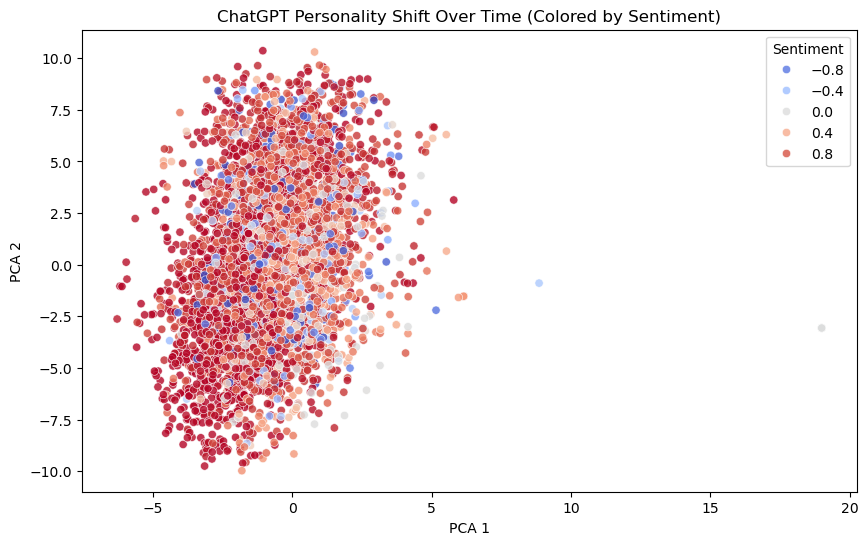

In [59]:
# -----------------------------
# STEP 4: PCA for embeddings (visualizing evolution)
# -----------------------------
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

assistant_df["pca1"] = X_pca[:, 0]
assistant_df["pca2"] = X_pca[:, 1]

# -----------------------------
# STEP 5: Plotting evolution
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=assistant_df, x="pca1", y="pca2", hue="compound", palette="coolwarm", alpha=0.8)
plt.title("ChatGPT Personality Shift Over Time (Colored by Sentiment)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Sentiment")
plt.show()


In [65]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np
from collections import Counter

# Load model + tokenizer once
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)
emotion_pipeline = pipeline("text-classification", model=emotion_model, tokenizer=emotion_tokenizer, return_all_scores=True)

def chunk_text(text, max_tokens=510, stride=490):
    """Split long text into overlapping chunks of max_tokens"""
    input_ids = emotion_tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    for i in range(0, len(input_ids), stride):
        chunk = input_ids[i:i+max_tokens]
        if chunk:
            chunk_text = emotion_tokenizer.decode(chunk, skip_special_tokens=True)
            chunks.append(chunk_text)
    return chunks

def get_emotion_distribution(text):
    """Run emotion classification on chunks and average scores"""
    chunks = chunk_text(text)
    emotion_scores = []

    for chunk in chunks:
        results = emotion_pipeline(chunk)[0]  # List of dicts
        scores = {res['label']: res['score'] for res in results}
        emotion_scores.append(scores)

    # Aggregate: mean score per label
    all_labels = emotion_scores[0].keys()
    avg_scores = {label: np.mean([chunk_scores[label] for chunk_scores in emotion_scores])
                  for label in all_labels}
    
    # Return most probable label and full distribution
    top_label = max(avg_scores, key=avg_scores.get)
    return top_label, avg_scores


Device set to use cpu
c:\Users\adith\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [66]:
# Just sentiment scores is not giving... So let's try to analyze a bit deeper.
# Some questions to ground myself - Does GPT mirror me? Do I show some form of mirroring, aka its style changes my style?
# If so, does it pick up on that and change itself? [Aka is that positive reward]
# Okay so step one is to do a more enhanced sentiment or tone analysis

import pandas as pd
import nltk
from textblob import TextBlob
from empath import Empath
import textstat 
from transformers import pipeline
import re

nltk.download('punkt')
lexicon = Empath()
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)

def extract_features(df):
    features = []

    for i, row in df.iterrows():
        content = row['content']
        author = row['author']
        message_time = row['message_time']
        blob = TextBlob(content)

        # Sentiment
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # Emotion
        emotion, emotion_dist = get_emotion_distribution(content) if len(content.split()) > 3 else (None, None)

        # Empath Topics
        empath_scores = lexicon.analyze(content, categories=["emotional", "affection", "aggression", "confusion", "curiosity"])

        # Readability
        r = textstat.flesch_reading_ease(content)
        try:
            flesch = r.flesch().score
        except:
            flesch = None

        # Stylistic heuristics
        avg_sentence_len = sum(len(s.split()) for s in nltk.sent_tokenize(content)) / max(1, len(nltk.sent_tokenize(content)))
        num_questions = content.count('?')
        exclamations = content.count('!')
        first_person = len(re.findall(r"\bI\b|\bme\b|\bmy\b", content))
        second_person = len(re.findall(r"\byou\b|\byour\b", content))

        features.append({
            "author": author,
            "content": content,
            "message_time": message_time,
            "polarity": polarity,
            "subjectivity": subjectivity,
            "emotion": emotion,
            "formality_proxy": flesch,
            "curiosity_score": empath_scores.get("curiosity", 0),
            "affection_score": empath_scores.get("affection", 0),
            "aggression_score": empath_scores.get("aggression", 0),
            "confusion_score": empath_scores.get("confusion", 0),
            "avg_sentence_len": avg_sentence_len,
            "num_questions": num_questions,
            "exclamations": exclamations,
            "first_person_count": first_person,
            "second_person_count": second_person
        })

    return pd.DataFrame(features)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use cpu


In [ ]:
features_df = extract_features(df)
features_df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (1377 > 512). Running this sequence through the model will result in indexing errors
